# Day 44: t-SNE - t-distributed Stochastic Neighbor Embedding

Welcome to Day 44 of the 100 Days of Machine Learning Challenge! Today, we explore one of the most powerful dimensionality reduction techniques for data visualization: **t-distributed Stochastic Neighbor Embedding (t-SNE)**.

## Introduction

t-SNE is a non-linear dimensionality reduction technique that is particularly well-suited for visualizing high-dimensional data in two or three dimensions. Unlike linear methods such as PCA (Principal Component Analysis), t-SNE can capture complex non-linear relationships in the data, making it invaluable for exploring and understanding the structure of high-dimensional datasets.

Developed by Laurens van der Maaten and Geoffrey Hinton in 2008, t-SNE has become one of the most popular techniques in machine learning for visualizing complex datasets, especially in fields like genomics, image analysis, natural language processing, and more.

## Why t-SNE Matters

In modern machine learning, we often work with datasets that have hundreds or thousands of features. Understanding the structure and patterns in such high-dimensional data is crucial but challenging:

1. **Curse of Dimensionality**: As dimensions increase, data becomes sparse, making it difficult to identify patterns.
2. **Visualization Limitations**: Humans can only visualize data in 2D or 3D effectively.
3. **Non-linear Relationships**: Real-world data often has complex, non-linear structures that linear methods cannot capture.

t-SNE addresses these challenges by:
- Preserving local structure: Similar points in high-dimensional space remain close in the low-dimensional embedding
- Revealing clusters: Natural groupings in the data become visually apparent
- Capturing non-linear patterns: Can model complex manifolds that linear methods miss

## Learning Objectives

By the end of this lesson, you will be able to:

1. Understand the mathematical principles behind t-SNE
2. Explain the difference between linear (PCA) and non-linear (t-SNE) dimensionality reduction
3. Implement t-SNE using scikit-learn for various datasets
4. Tune t-SNE hyperparameters (perplexity, learning rate, iterations)
5. Visualize high-dimensional data effectively using t-SNE
6. Understand the limitations and best practices of t-SNE

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris, load_digits, make_classification
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## Theory: Understanding t-SNE

### What is Dimensionality Reduction?

**Dimensionality reduction** is the process of reducing the number of features (dimensions) in a dataset while retaining as much information as possible. There are two main types:

1. **Linear Methods** (e.g., PCA): Assume data lies on or near a linear subspace
2. **Non-linear Methods** (e.g., t-SNE): Can model complex, non-linear manifolds

### The Core Idea of t-SNE

t-SNE works by converting high-dimensional Euclidean distances between data points into conditional probabilities that represent similarities. The algorithm then tries to find a low-dimensional representation that preserves these similarities as much as possible.

**The process has two main steps:**

1. **High-Dimensional Space**: Compute pairwise similarities between points using Gaussian distributions
2. **Low-Dimensional Space**: Model similarities using t-distributions and minimize the difference

### Mathematical Foundation

#### Step 1: Computing Similarities in High-Dimensional Space

For each pair of data points $x_i$ and $x_j$ in the high-dimensional space, we compute the conditional probability $p_{j|i}$ that $x_i$ would pick $x_j$ as its neighbor:

$$p_{j|i} = \frac{\exp(-||x_i - x_j||^2 / 2\sigma_i^2)}{\sum_{k \neq i} \exp(-||x_i - x_k||^2 / 2\sigma_i^2)}$$

where:
- $||x_i - x_j||^2$ is the squared Euclidean distance between points $x_i$ and $x_j$
- $\sigma_i$ is the variance of the Gaussian centered at $x_i$ (determined by perplexity)

The joint probability is then:

$$p_{ij} = \frac{p_{j|i} + p_{i|j}}{2n}$$

where $n$ is the number of data points.

#### Step 2: Computing Similarities in Low-Dimensional Space

In the low-dimensional space (usually 2D or 3D), we use a **Student t-distribution** with one degree of freedom instead of a Gaussian:

$$q_{ij} = \frac{(1 + ||y_i - y_j||^2)^{-1}}{\sum_{k \neq l} (1 + ||y_k - y_l||^2)^{-1}}$$

where $y_i$ and $y_j$ are the low-dimensional representations of $x_i$ and $x_j$.

**Why use t-distribution?** The t-distribution has heavier tails than the Gaussian, which helps:
- Moderate distances in high-dimensional space map to larger distances in low-dimensional space
- Alleviate the "crowding problem" where there isn't enough space in low dimensions

#### Step 3: Minimizing the Difference

The algorithm finds the low-dimensional representation by minimizing the **Kullback-Leibler (KL) divergence** between the two probability distributions:

$$KL(P||Q) = \sum_{i} \sum_{j} p_{ij} \log \frac{p_{ij}}{q_{ij}}$$

This is optimized using **gradient descent**. The gradient is:

$$\frac{\delta KL(P||Q)}{\delta y_i} = 4 \sum_{j} (p_{ij} - q_{ij})(y_i - y_j)(1 + ||y_i - y_j||^2)^{-1}$$

### Key Hyperparameters

1. **Perplexity** (typically 5-50): 
   - A measure of the effective number of neighbors
   - Related to the variance $\sigma_i$ of the Gaussian distributions
   - Balances local vs global structure preservation
   - Rule of thumb: perplexity should be less than the number of points

2. **Learning Rate** (typically 10-1000):
   - Controls the step size in gradient descent
   - Too high: unstable optimization
   - Too low: slow convergence, local minima

3. **Number of Iterations** (typically 1000+):
   - More iterations → better optimization
   - Should run until convergence (KL divergence stabilizes)

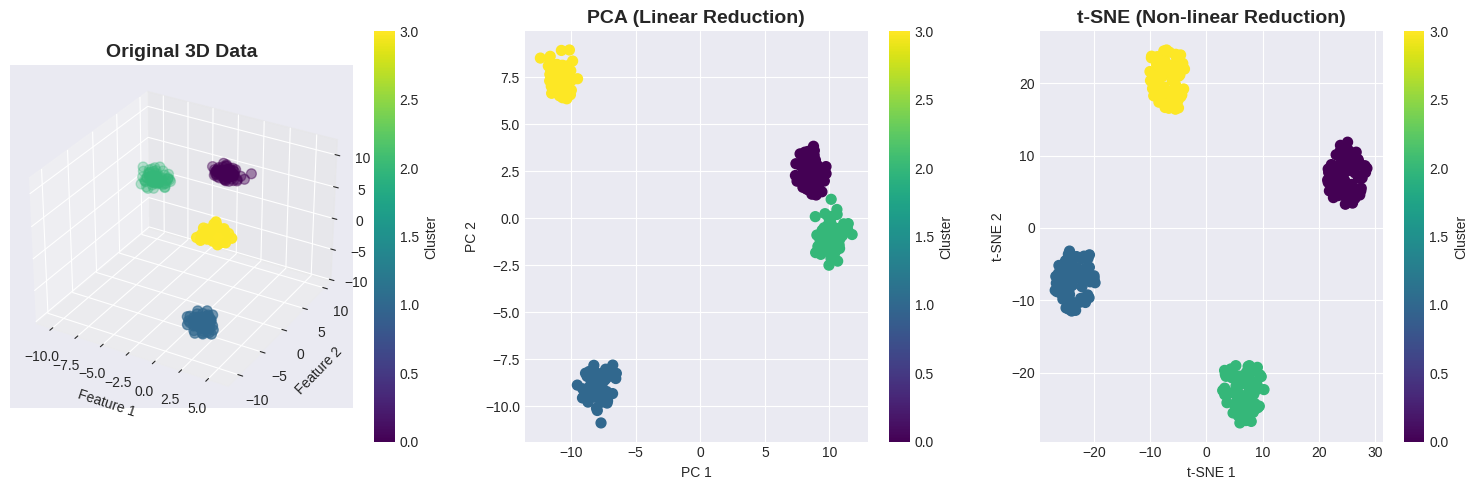


Observation:
- Original: 4 clusters in 3D space
- PCA explained variance: 96.09%
- t-SNE: Preserves cluster separation better than PCA in this case


In [2]:
# Create a simple synthetic dataset with clear clusters
from sklearn.datasets import make_blobs

# Generate 3D data with 4 clusters
X_simple, y_simple = make_blobs(n_samples=300, n_features=3, centers=4, 
                                 cluster_std=0.60, random_state=42)

# Visualize the original 3D data
fig = plt.figure(figsize=(15, 5))

# Plot 1: Original 3D data
ax1 = fig.add_subplot(131, projection='3d')
scatter1 = ax1.scatter(X_simple[:, 0], X_simple[:, 1], X_simple[:, 2], 
                       c=y_simple, cmap='viridis', s=50)
ax1.set_title('Original 3D Data', fontsize=14, fontweight='bold')
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
ax1.set_zlabel('Feature 3')
plt.colorbar(scatter1, ax=ax1, label='Cluster')

# Plot 2: PCA reduction to 2D
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_simple)

ax2 = fig.add_subplot(132)
scatter2 = ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=y_simple, cmap='viridis', s=50)
ax2.set_title('PCA (Linear Reduction)', fontsize=14, fontweight='bold')
ax2.set_xlabel('PC 1')
ax2.set_ylabel('PC 2')
plt.colorbar(scatter2, ax=ax2, label='Cluster')

# Plot 3: t-SNE reduction to 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_simple)

ax3 = fig.add_subplot(133)
scatter3 = ax3.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_simple, cmap='viridis', s=50)
ax3.set_title('t-SNE (Non-linear Reduction)', fontsize=14, fontweight='bold')
ax3.set_xlabel('t-SNE 1')
ax3.set_ylabel('t-SNE 2')
plt.colorbar(scatter3, ax=ax3, label='Cluster')

plt.tight_layout()
plt.show()

print("\nObservation:")
print("- Original: 4 clusters in 3D space")
print(f"- PCA explained variance: {pca.explained_variance_ratio_.sum():.2%}")
print("- t-SNE: Preserves cluster separation better than PCA in this case")

## Practical Implementation: Iris Dataset

Let's apply t-SNE to the classic Iris dataset, which has 4 features and 3 species classes. This will help us understand how t-SNE reveals the structure in the data.

Iris dataset shape: (150, 4)
Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Classes: ['setosa' 'versicolor' 'virginica']


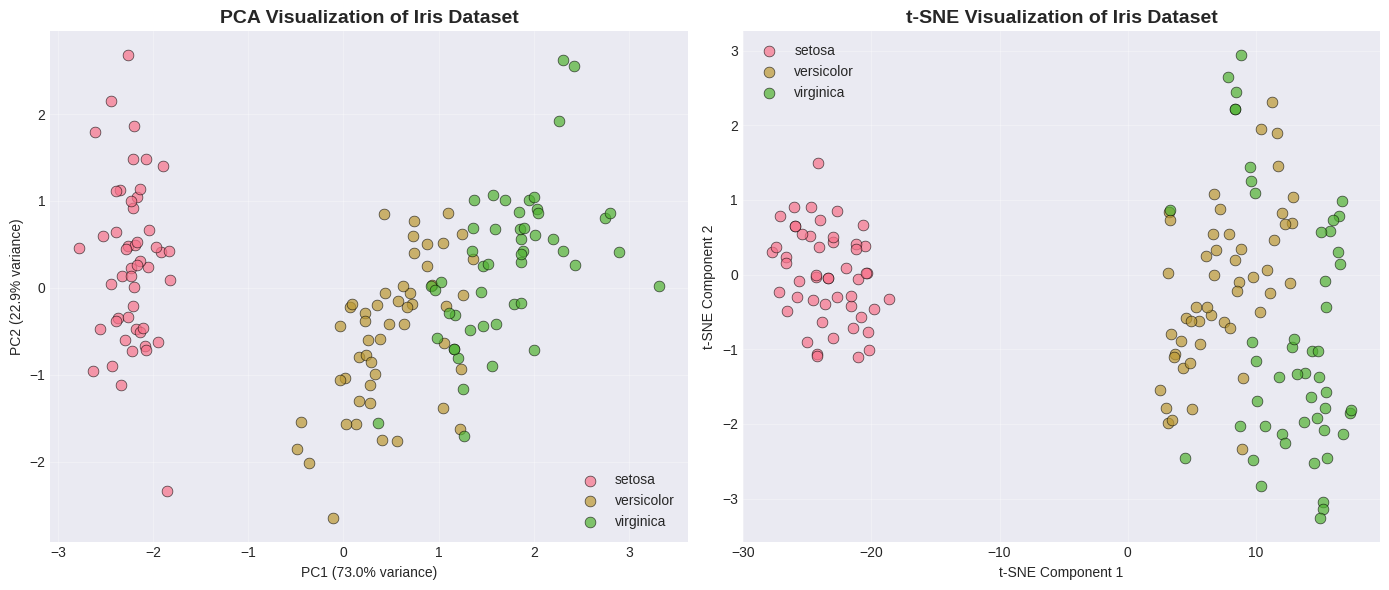


PCA total explained variance: 95.81%

t-SNE creates clearer separation between species, especially for overlapping classes.


In [3]:
# Load the Iris dataset
iris = load_iris()
X_iris = iris.data
y_iris = iris.target
species_names = iris.target_names

print(f"Iris dataset shape: {X_iris.shape}")
print(f"Features: {iris.feature_names}")
print(f"Classes: {species_names}")

# Standardize the features (important for distance-based methods)
scaler = StandardScaler()
X_iris_scaled = scaler.fit_transform(X_iris)

# Apply PCA
pca_iris = PCA(n_components=2, random_state=42)
X_iris_pca = pca_iris.fit_transform(X_iris_scaled)

# Apply t-SNE
tsne_iris = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
X_iris_tsne = tsne_iris.fit_transform(X_iris_scaled)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# PCA plot
for i, name in enumerate(species_names):
    mask = y_iris == i
    axes[0].scatter(X_iris_pca[mask, 0], X_iris_pca[mask, 1], 
                    label=name, s=60, alpha=0.7, edgecolors='black', linewidth=0.5)
axes[0].set_title('PCA Visualization of Iris Dataset', fontsize=14, fontweight='bold')
axes[0].set_xlabel(f'PC1 ({pca_iris.explained_variance_ratio_[0]:.1%} variance)')
axes[0].set_ylabel(f'PC2 ({pca_iris.explained_variance_ratio_[1]:.1%} variance)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# t-SNE plot
for i, name in enumerate(species_names):
    mask = y_iris == i
    axes[1].scatter(X_iris_tsne[mask, 0], X_iris_tsne[mask, 1], 
                    label=name, s=60, alpha=0.7, edgecolors='black', linewidth=0.5)
axes[1].set_title('t-SNE Visualization of Iris Dataset', fontsize=14, fontweight='bold')
axes[1].set_xlabel('t-SNE Component 1')
axes[1].set_ylabel('t-SNE Component 2')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPCA total explained variance: {pca_iris.explained_variance_ratio_.sum():.2%}")
print("\nt-SNE creates clearer separation between species, especially for overlapping classes.")

## Hyperparameter Tuning: The Role of Perplexity

**Perplexity** is the most important hyperparameter in t-SNE. It balances attention between local and global aspects of the data:

- **Low perplexity (5-15)**: Focuses on local structure, may split natural clusters
- **Medium perplexity (20-50)**: Balanced view, good for most datasets
- **High perplexity (50-100)**: Focuses on global structure, may merge distinct clusters

The original paper recommends perplexity between 5 and 50, with 30 being a good default.

Let's see how different perplexity values affect the visualization:

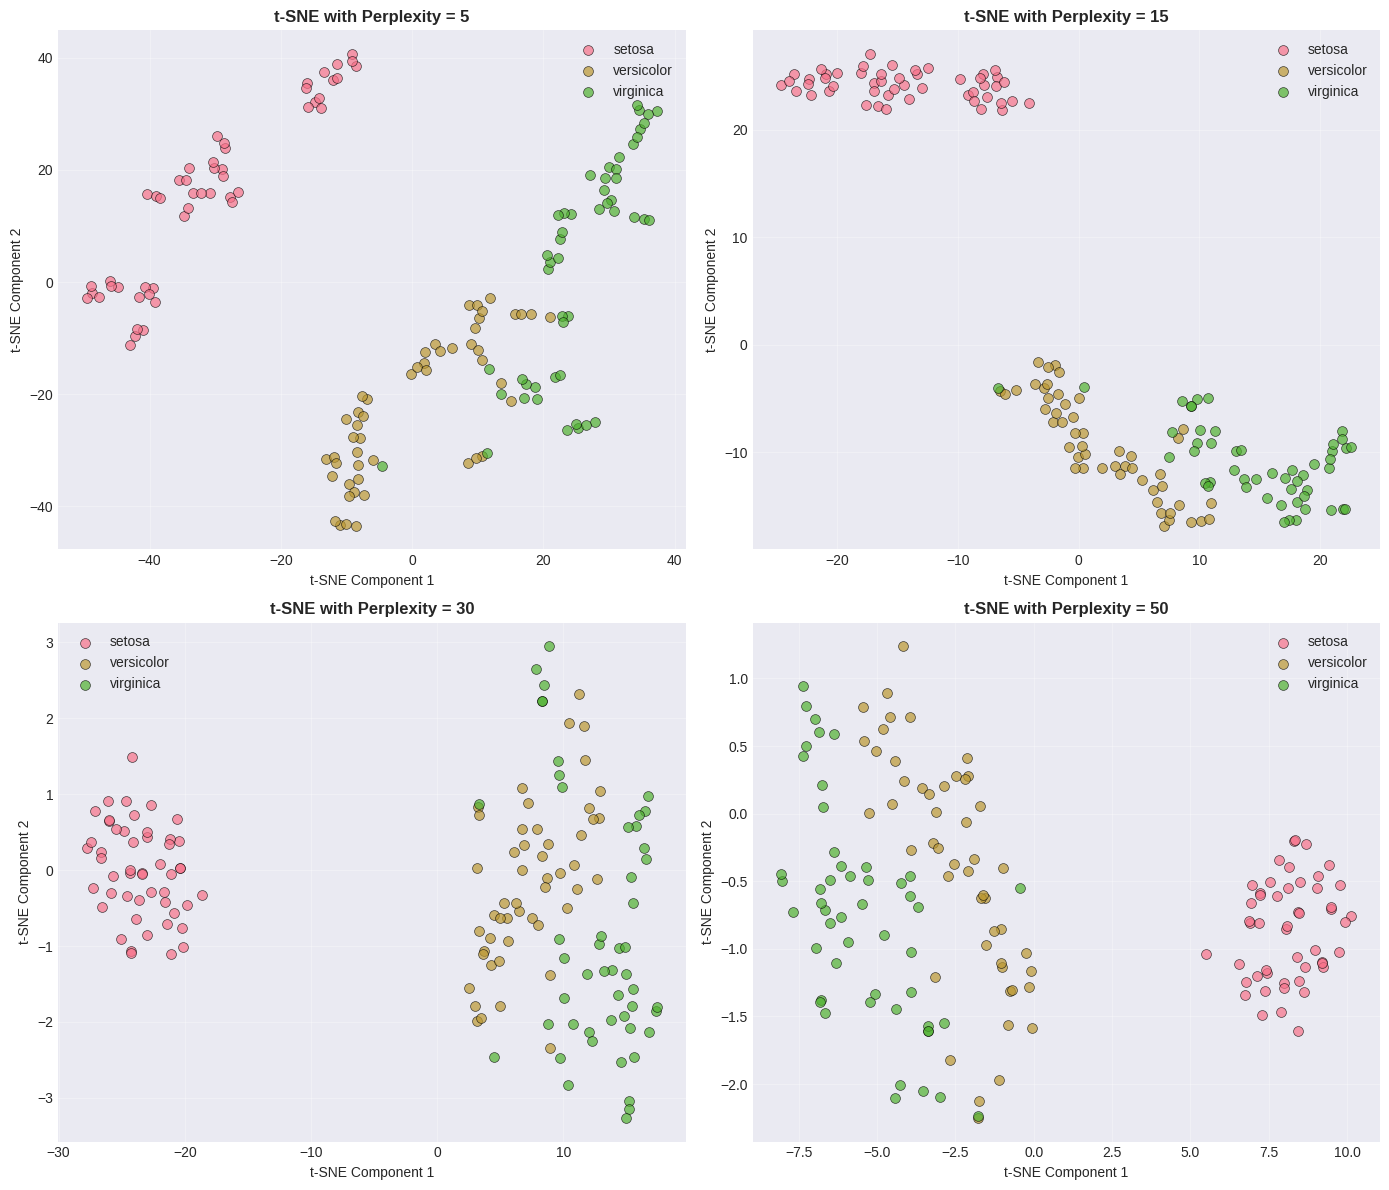


Observations:
- Low perplexity (5): May create fragmented clusters
- Medium perplexity (15-30): Good balance, clear separation
- High perplexity (50): May compress clusters together

Recommendation: Start with perplexity=30, then experiment based on your data size


In [4]:
# Test different perplexity values
perplexities = [5, 15, 30, 50]

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, perp in enumerate(perplexities):
    # Apply t-SNE with different perplexity
    tsne_temp = TSNE(n_components=2, perplexity=perp, max_iter=1000, random_state=42)
    X_embedded = tsne_temp.fit_transform(X_iris_scaled)
    
    # Plot
    for i, name in enumerate(species_names):
        mask = y_iris == i
        axes[idx].scatter(X_embedded[mask, 0], X_embedded[mask, 1], 
                         label=name, s=50, alpha=0.7, edgecolors='black', linewidth=0.5)
    
    axes[idx].set_title(f't-SNE with Perplexity = {perp}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('t-SNE Component 1')
    axes[idx].set_ylabel('t-SNE Component 2')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nObservations:")
print("- Low perplexity (5): May create fragmented clusters")
print("- Medium perplexity (15-30): Good balance, clear separation")
print("- High perplexity (50): May compress clusters together")
print("\nRecommendation: Start with perplexity=30, then experiment based on your data size")

## Advanced Example: MNIST Digits Dataset

Now let's apply t-SNE to a more complex dataset: the MNIST digits dataset. Each digit is represented by 64 features (8x8 pixel values). We'll visualize how t-SNE can reveal the natural clustering of different digit classes in high-dimensional space.

Digits dataset shape: (1797, 64)
Number of features: 64
Number of samples: 1797
Digit classes: [0 1 2 3 4 5 6 7 8 9]


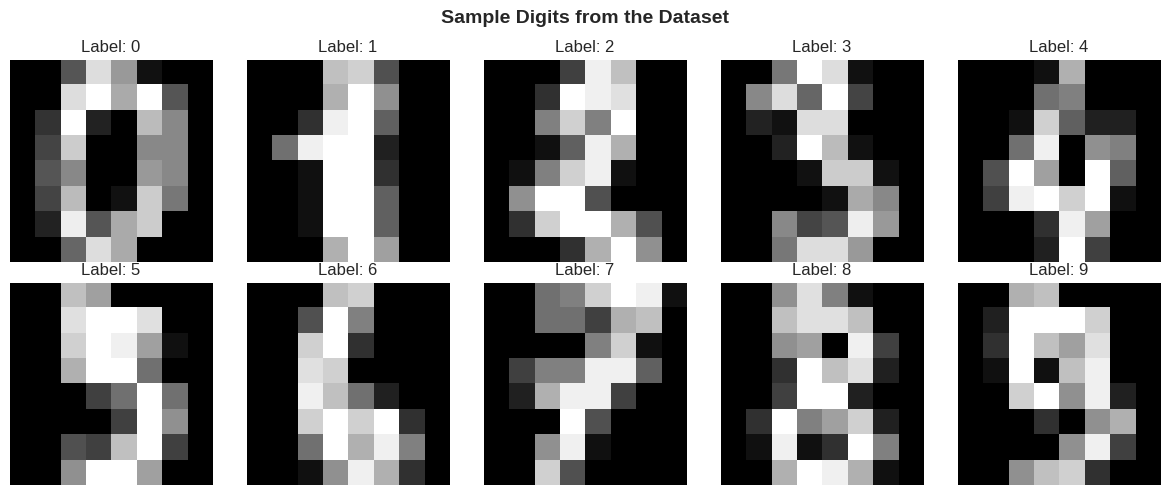


Applying dimensionality reduction (this may take a minute)...


In [5]:
# Load digits dataset
digits = load_digits()
X_digits = digits.data
y_digits = digits.target

print(f"Digits dataset shape: {X_digits.shape}")
print(f"Number of features: {X_digits.shape[1]}")
print(f"Number of samples: {X_digits.shape[0]}")
print(f"Digit classes: {np.unique(y_digits)}")

# Display a few example digits
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='gray')
    ax.set_title(f'Label: {y_digits[i]}')
    ax.axis('off')
plt.suptitle('Sample Digits from the Dataset', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Standardize the features
X_digits_scaled = StandardScaler().fit_transform(X_digits)

print("\nApplying dimensionality reduction (this may take a minute)...")

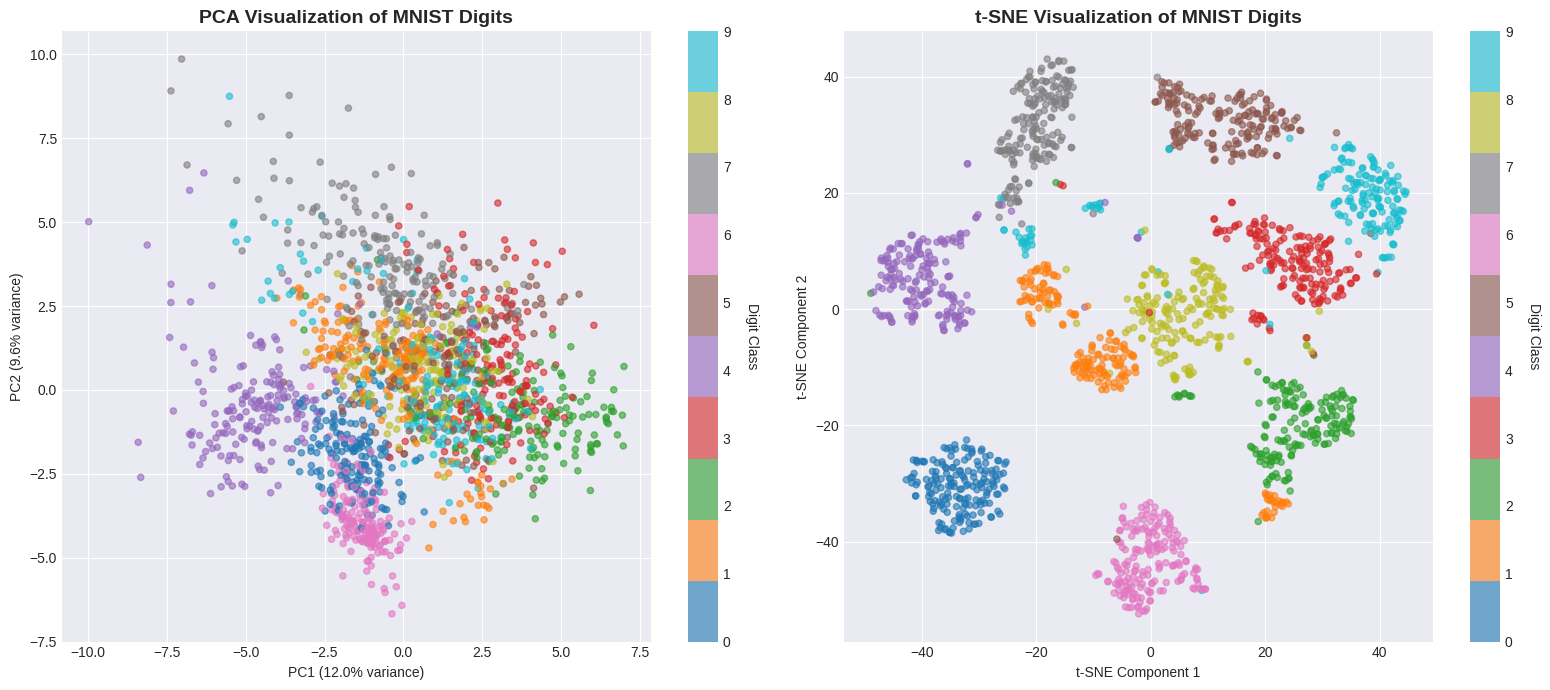


PCA Results:
  - Explained variance (2 components): 21.59%
  - Many digit classes overlap significantly

t-SNE Results:
  - Creates distinct, well-separated clusters for each digit
  - Reveals the non-linear manifold structure of the data
  - Much better visualization for understanding digit relationships


In [6]:
# Apply PCA
pca_digits = PCA(n_components=2, random_state=42)
X_digits_pca = pca_digits.fit_transform(X_digits_scaled)

# Apply t-SNE
tsne_digits = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42, verbose=0)
X_digits_tsne = tsne_digits.fit_transform(X_digits_scaled)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# PCA plot
scatter1 = axes[0].scatter(X_digits_pca[:, 0], X_digits_pca[:, 1], 
                          c=y_digits, cmap='tab10', s=20, alpha=0.6)
axes[0].set_title('PCA Visualization of MNIST Digits', fontsize=14, fontweight='bold')
axes[0].set_xlabel(f'PC1 ({pca_digits.explained_variance_ratio_[0]:.1%} variance)')
axes[0].set_ylabel(f'PC2 ({pca_digits.explained_variance_ratio_[1]:.1%} variance)')
cbar1 = plt.colorbar(scatter1, ax=axes[0])
cbar1.set_label('Digit Class', rotation=270, labelpad=20)

# t-SNE plot
scatter2 = axes[1].scatter(X_digits_tsne[:, 0], X_digits_tsne[:, 1], 
                          c=y_digits, cmap='tab10', s=20, alpha=0.6)
axes[1].set_title('t-SNE Visualization of MNIST Digits', fontsize=14, fontweight='bold')
axes[1].set_xlabel('t-SNE Component 1')
axes[1].set_ylabel('t-SNE Component 2')
cbar2 = plt.colorbar(scatter2, ax=axes[1])
cbar2.set_label('Digit Class', rotation=270, labelpad=20)

plt.tight_layout()
plt.show()

print(f"\nPCA Results:")
print(f"  - Explained variance (2 components): {pca_digits.explained_variance_ratio_.sum():.2%}")
print(f"  - Many digit classes overlap significantly")
print(f"\nt-SNE Results:")
print(f"  - Creates distinct, well-separated clusters for each digit")
print(f"  - Reveals the non-linear manifold structure of the data")
print(f"  - Much better visualization for understanding digit relationships")

## PCA vs t-SNE: When to Use Which?

### Principal Component Analysis (PCA)

**Pros:**
- Fast computation, even for large datasets
- Deterministic (same input always gives same output)
- Preserves global structure
- Can be used for preprocessing before other algorithms
- Components are interpretable (linear combinations of features)
- Can project new data into the reduced space

**Cons:**
- Only captures linear relationships
- May not reveal complex patterns
- Assumes variance equals importance

**Use PCA when:**
- You need fast dimensionality reduction
- Data has linear structure
- You need to reduce dimensions for other algorithms (preprocessing)
- You want interpretable components
- You need to project new data into reduced space

### t-distributed Stochastic Neighbor Embedding (t-SNE)

**Pros:**
- Captures non-linear relationships
- Excellent for visualization (2D/3D)
- Reveals natural clusters
- Preserves local structure very well

**Cons:**
- Computationally expensive (slow on large datasets)
- Stochastic (different runs give different results)
- Distances in t-SNE space don't have clear interpretation
- Cannot project new data (must rerun entire algorithm)
- Sensitive to hyperparameters
- Global structure not always preserved

**Use t-SNE when:**
- You need to visualize high-dimensional data
- Data has non-linear structure
- You want to explore natural clusters
- Dataset is not too large (< 10,000 points ideally)
- Computational time is not critical

### Practical Workflow

1. **Exploration**: Use t-SNE to visualize and understand your data
2. **Preprocessing**: Use PCA to reduce dimensions before other ML algorithms
3. **Combined approach**: Apply PCA first (to ~50 dimensions), then t-SNE for visualization

This combined approach leverages PCA's speed and t-SNE's quality!

## Best Practices and Important Considerations

### 1. Preprocessing is Critical

Always standardize your data before applying t-SNE:

```python
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
```

### 2. Use PCA for Initial Dimensionality Reduction

For very high-dimensional data, reduce to 50-100 dimensions with PCA first:

```python
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_pca)
```

### 3. Perplexity Guidelines

- **Small datasets (< 100 points)**: perplexity = 5-15
- **Medium datasets (100-5000 points)**: perplexity = 20-50
- **Large datasets (> 5000 points)**: perplexity = 30-100
- Always: perplexity < number of points

### 4. Sufficient Iterations

Use at least 1000 iterations, more for complex data:

```python
tsne = TSNE(max_iter=1000, n_iter_without_progress=300)
```

### 5. Multiple Runs

t-SNE is stochastic. Run it multiple times with different random seeds:

```python
for seed in [42, 123, 456]:
    tsne = TSNE(random_state=seed)
    X_embedded = tsne.fit_transform(X)
    # visualize
```

### 6. Interpreting t-SNE Plots

**What you CAN interpret:**
- Cluster structure (which points group together)
- Relative proximity (nearby points are similar)

**What you CANNOT interpret:**
- Absolute distances between clusters
- Cluster sizes (can be artifacts)
- Axes directions (no meaning like PCA)

### 7. Common Pitfalls to Avoid

- **Don't** use t-SNE for feature extraction in ML pipelines
- **Don't** over-interpret distances between far-apart clusters
- **Don't** assume cluster sizes are meaningful
- **Don't** use default parameters without experimentation
- **Don't** forget to scale your data

### 8. Computational Considerations

t-SNE has O(n²) time complexity. For large datasets:

- Use PCA preprocessing
- Sample your data
- Consider Barnes-Hut approximation (enabled by default in sklearn)
- Use `method='exact'` only for small datasets (< 1000 points)

## Hands-On Exercise: Complete t-SNE Analysis Pipeline

Now it's your turn! We'll work through a complete analysis of a high-dimensional dataset using both PCA and t-SNE.

### Task:

1. Create a synthetic classification dataset with 10 classes
2. Apply both PCA and t-SNE
3. Compare the results
4. Experiment with different perplexity values
5. Analyze which method better reveals the class structure

Dataset shape: (1000, 50)
Number of classes: 10
Samples per class:
  Class 0: 102 samples
  Class 1: 101 samples
  Class 2: 98 samples
  Class 3: 98 samples
  Class 4: 101 samples
  Class 5: 101 samples
  Class 6: 101 samples
  Class 7: 100 samples
  Class 8: 100 samples
  Class 9: 98 samples

Applying PCA...
Applying t-SNE with different perplexities...
  - Perplexity 10...


  - Perplexity 30...


  - Perplexity 50...


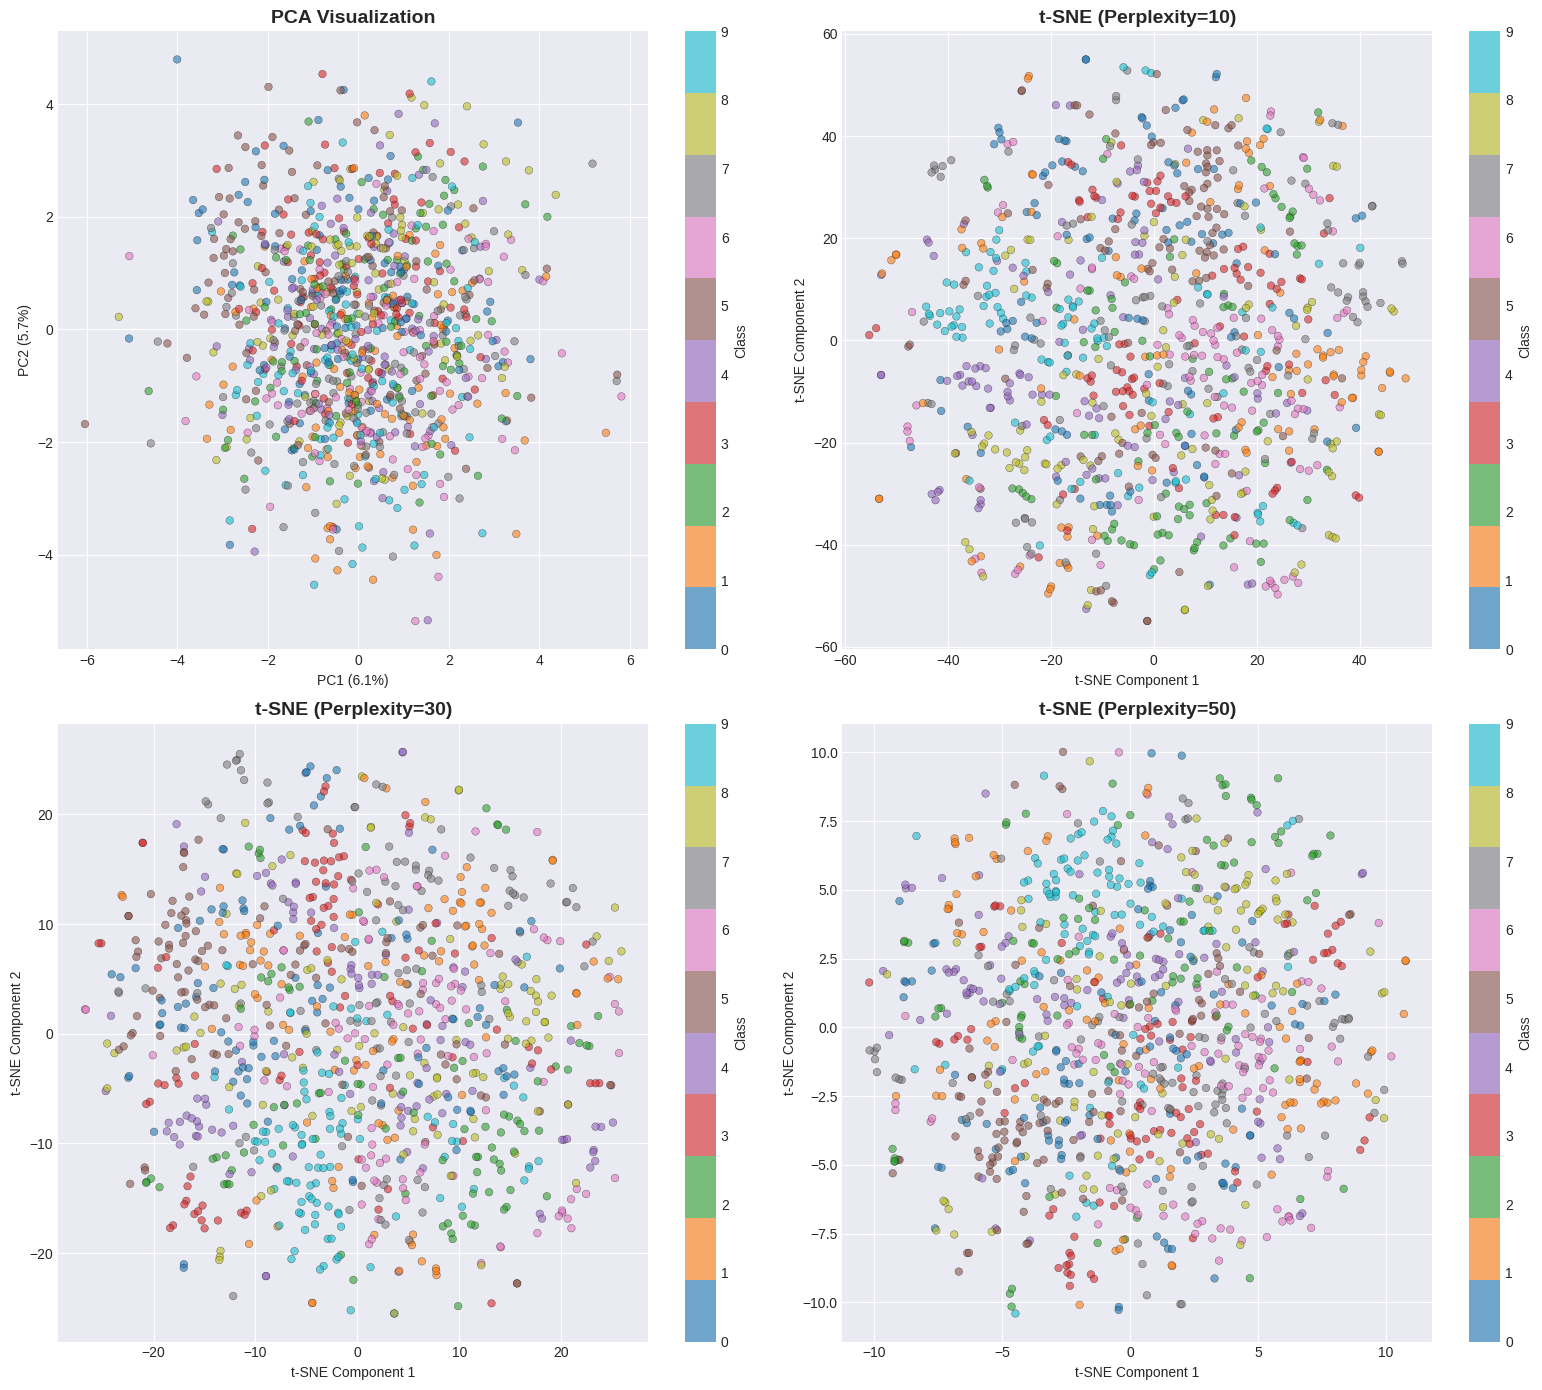


ANALYSIS:
PCA Explained Variance: 11.75%

Observations:
1. PCA shows some separation but many classes overlap
2. t-SNE with perplexity=10: Very tight, separated clusters (may be too local)
3. t-SNE with perplexity=30: Good balance, clear class separation
4. t-SNE with perplexity=50: More global view, some clusters may merge

Conclusion: t-SNE better reveals the 10-class structure in this dataset!


In [7]:
# Create a complex synthetic dataset
X_complex, y_complex = make_classification(
    n_samples=1000,
    n_features=50,
    n_informative=30,
    n_redundant=10,
    n_classes=10,
    n_clusters_per_class=1,
    class_sep=0.8,
    random_state=42
)

print(f"Dataset shape: {X_complex.shape}")
print(f"Number of classes: {len(np.unique(y_complex))}")
print(f"Samples per class:")
unique, counts = np.unique(y_complex, return_counts=True)
for label, count in zip(unique, counts):
    print(f"  Class {label}: {count} samples")

# Standardize
scaler = StandardScaler()
X_complex_scaled = scaler.fit_transform(X_complex)

# Step 1: Apply PCA
print("\nApplying PCA...")
pca_complex = PCA(n_components=2, random_state=42)
X_complex_pca = pca_complex.fit_transform(X_complex_scaled)

# Step 2: Apply t-SNE with different perplexities
print("Applying t-SNE with different perplexities...")
perplexity_values = [10, 30, 50]
tsne_results = {}

for perp in perplexity_values:
    print(f"  - Perplexity {perp}...")
    tsne_temp = TSNE(n_components=2, perplexity=perp, max_iter=1000, random_state=42, verbose=0)
    tsne_results[perp] = tsne_temp.fit_transform(X_complex_scaled)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# PCA
scatter0 = axes[0, 0].scatter(X_complex_pca[:, 0], X_complex_pca[:, 1], 
                              c=y_complex, cmap='tab10', s=30, alpha=0.6, edgecolors='black', linewidth=0.3)
axes[0, 0].set_title('PCA Visualization', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel(f'PC1 ({pca_complex.explained_variance_ratio_[0]:.1%})')
axes[0, 0].set_ylabel(f'PC2 ({pca_complex.explained_variance_ratio_[1]:.1%})')
plt.colorbar(scatter0, ax=axes[0, 0], label='Class')

# t-SNE with different perplexities
positions = [(0, 1), (1, 0), (1, 1)]
for (i, j), perp in zip(positions, perplexity_values):
    X_embedded = tsne_results[perp]
    scatter = axes[i, j].scatter(X_embedded[:, 0], X_embedded[:, 1], 
                                c=y_complex, cmap='tab10', s=30, alpha=0.6, 
                                edgecolors='black', linewidth=0.3)
    axes[i, j].set_title(f't-SNE (Perplexity={perp})', fontsize=14, fontweight='bold')
    axes[i, j].set_xlabel('t-SNE Component 1')
    axes[i, j].set_ylabel('t-SNE Component 2')
    plt.colorbar(scatter, ax=axes[i, j], label='Class')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("ANALYSIS:")
print("="*70)
print(f"PCA Explained Variance: {pca_complex.explained_variance_ratio_.sum():.2%}")
print("\nObservations:")
print("1. PCA shows some separation but many classes overlap")
print("2. t-SNE with perplexity=10: Very tight, separated clusters (may be too local)")
print("3. t-SNE with perplexity=30: Good balance, clear class separation")
print("4. t-SNE with perplexity=50: More global view, some clusters may merge")
print("\nConclusion: t-SNE better reveals the 10-class structure in this dataset!")

Demonstrating the PCA -> t-SNE pipeline...

Step 1: Reduce from 50 to 20 dimensions with PCA
  - Explained variance: 67.93%

Step 2: Apply t-SNE to the 20 PCA components


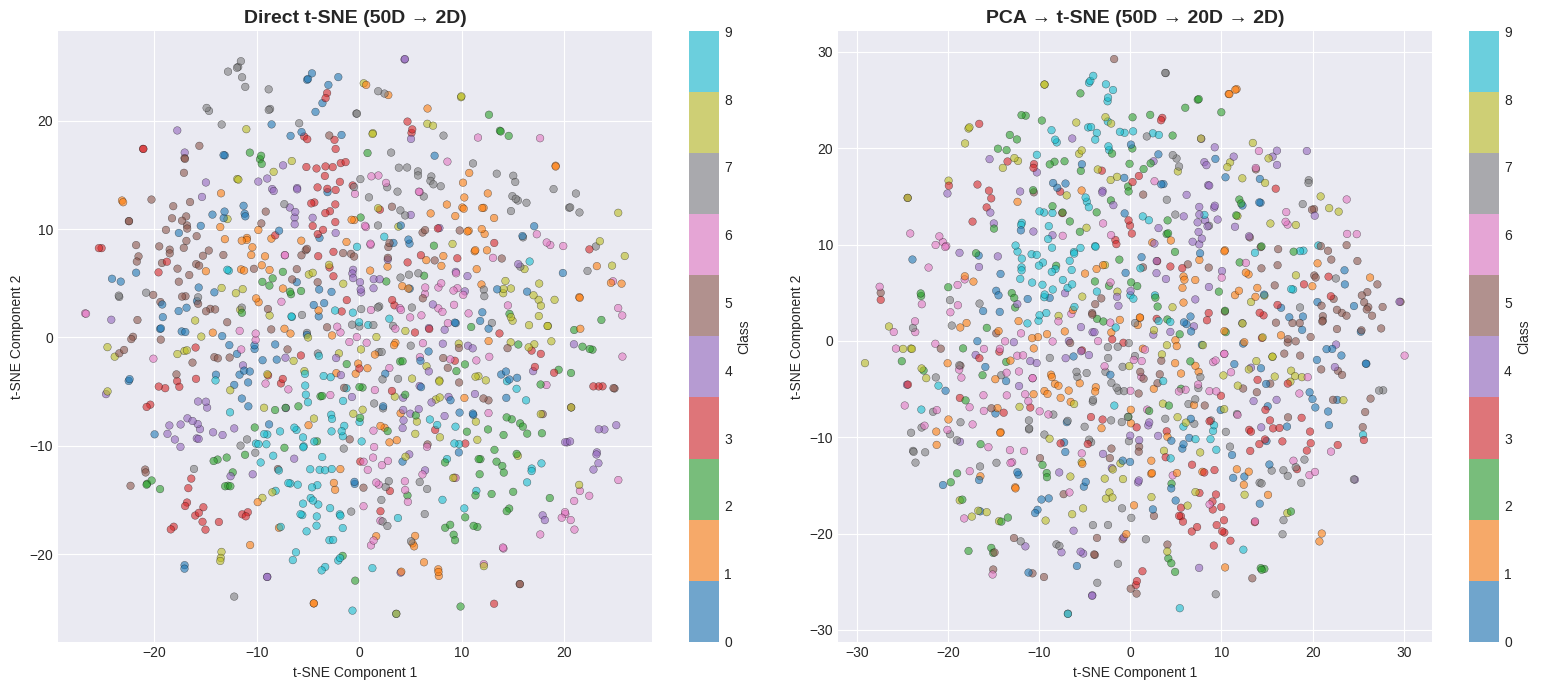


Benefits of PCA → t-SNE pipeline:
  ✓ Faster computation (t-SNE works on fewer dimensions)
  ✓ Removes noise (PCA filters out low-variance components)
  ✓ Often produces cleaner visualizations
  ✓ Recommended for datasets with > 50 features


In [8]:
# Best practice: Use PCA first, then t-SNE
print("Demonstrating the PCA -> t-SNE pipeline...")
print("\nStep 1: Reduce from 50 to 20 dimensions with PCA")

pca_intermediate = PCA(n_components=20, random_state=42)
X_pca_intermediate = pca_intermediate.fit_transform(X_complex_scaled)
print(f"  - Explained variance: {pca_intermediate.explained_variance_ratio_.sum():.2%}")

print("\nStep 2: Apply t-SNE to the 20 PCA components")
tsne_from_pca = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42, verbose=0)
X_tsne_from_pca = tsne_from_pca.fit_transform(X_pca_intermediate)

# Compare: direct t-SNE vs PCA->t-SNE
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Direct t-SNE
scatter1 = axes[0].scatter(tsne_results[30][:, 0], tsne_results[30][:, 1], 
                          c=y_complex, cmap='tab10', s=30, alpha=0.6, 
                          edgecolors='black', linewidth=0.3)
axes[0].set_title('Direct t-SNE (50D → 2D)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('t-SNE Component 1')
axes[0].set_ylabel('t-SNE Component 2')
plt.colorbar(scatter1, ax=axes[0], label='Class')

# PCA -> t-SNE
scatter2 = axes[1].scatter(X_tsne_from_pca[:, 0], X_tsne_from_pca[:, 1], 
                          c=y_complex, cmap='tab10', s=30, alpha=0.6, 
                          edgecolors='black', linewidth=0.3)
axes[1].set_title('PCA → t-SNE (50D → 20D → 2D)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('t-SNE Component 1')
axes[1].set_ylabel('t-SNE Component 2')
plt.colorbar(scatter2, ax=axes[1], label='Class')

plt.tight_layout()
plt.show()

print("\nBenefits of PCA → t-SNE pipeline:")
print("  ✓ Faster computation (t-SNE works on fewer dimensions)")
print("  ✓ Removes noise (PCA filters out low-variance components)")
print("  ✓ Often produces cleaner visualizations")
print("  ✓ Recommended for datasets with > 50 features")

## Key Takeaways

Congratulations! You've completed Day 44 on t-SNE. Here are the key points to remember:

### 1. Core Concepts
- **t-SNE** is a non-linear dimensionality reduction technique for visualization
- It converts high-dimensional Euclidean distances into probability distributions
- Uses **Gaussian distributions** in high-dimensional space and **t-distributions** in low-dimensional space
- Minimizes **KL divergence** between these distributions using gradient descent

### 2. When to Use t-SNE
- Visualizing high-dimensional data in 2D or 3D
- Exploring natural clusters in your data
- When data has non-linear structure
- For datasets with < 10,000 points (or use sampling for larger datasets)

### 3. Key Hyperparameters
- **Perplexity**: Balance between local and global structure (default: 30)
- **Learning rate**: Step size in optimization (default: 200)
- **Iterations**: Number of optimization steps (minimum: 1000)

### 4. Best Practices
- Always standardize your data first
- Use PCA for initial dimensionality reduction (50-100 components)
- Run t-SNE multiple times with different random seeds
- Experiment with different perplexity values
- Use sufficient iterations for convergence

### 5. Interpretation Guidelines
- **DO** interpret: cluster structure, relative proximity
- **DON'T** interpret: absolute distances, cluster sizes, axes meanings

### 6. PCA vs t-SNE
- **PCA**: Fast, deterministic, preserves global structure, linear
- **t-SNE**: Slow, stochastic, preserves local structure, non-linear
- **Best practice**: Use both! PCA for preprocessing, t-SNE for visualization

### 7. Common Applications
- Image data visualization (e.g., MNIST, ImageNet)
- Text embeddings visualization (e.g., word2vec, BERT)
- Single-cell RNA sequencing analysis
- Customer segmentation
- Anomaly detection visualization

### What You Should Be Able to Do Now:
- ✓ Explain how t-SNE works mathematically
- ✓ Implement t-SNE using scikit-learn
- ✓ Choose appropriate hyperparameters
- ✓ Compare PCA and t-SNE results
- ✓ Interpret t-SNE visualizations correctly
- ✓ Apply t-SNE to real-world datasets
- ✓ Understand when to use (and when not to use) t-SNE

## Further Resources

To deepen your understanding of t-SNE and dimensionality reduction, explore these resources:

### Original Papers
1. **t-SNE Original Paper**: [Visualizing Data using t-SNE](http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf) by van der Maaten & Hinton (2008)
   - The foundational paper introducing t-SNE

2. **How to Use t-SNE Effectively**: [Distill.pub Interactive Guide](https://distill.pub/2016/misread-tsne/)
   - Excellent interactive visualization showing common pitfalls

### Documentation
3. **Scikit-learn t-SNE Documentation**: [sklearn.manifold.TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)
   - Official API documentation with examples

4. **Scikit-learn Manifold Learning Guide**: [Manifold Learning](https://scikit-learn.org/stable/modules/manifold.html)
   - Comprehensive guide to dimensionality reduction techniques

### Tutorials and Guides
5. **StatQuest Video on t-SNE**: [StatQuest: t-SNE, Clearly Explained](https://www.youtube.com/watch?v=NEaUSP4YerM)
   - Intuitive video explanation of t-SNE

6. **Towards Data Science**: [t-SNE Python Example](https://towardsdatascience.com/t-sne-python-example-1ded9953f26)
   - Practical tutorial with code examples

### Advanced Topics
7. **UMAP**: [Uniform Manifold Approximation and Projection](https://umap-learn.readthedocs.io/)
   - Modern alternative to t-SNE with better scalability

8. **OpenTSNE**: [Fast t-SNE Implementation](https://opentsne.readthedocs.io/)
   - Optimized t-SNE library for large datasets

### Interactive Tools
9. **TensorFlow Embedding Projector**: [projector.tensorflow.org](https://projector.tensorflow.org/)
   - Interactive tool to visualize embeddings with t-SNE

### Books
10. **Hands-On Machine Learning** by Aurélien Géron
    - Chapter on dimensionality reduction with practical examples

### Practice Datasets
- **MNIST**: Handwritten digits (sklearn.datasets.load_digits)
- **Fashion MNIST**: Clothing images
- **20 Newsgroups**: Text classification dataset
- **Single Cell RNA-seq**: Genomics data (scanpy library)

---

**Next Steps:**
- Apply t-SNE to your own datasets
- Compare t-SNE with other dimensionality reduction techniques (PCA, LDA, UMAP)
- Explore advanced visualization techniques
- Study the mathematical foundations more deeply

Keep experimenting and visualizing! t-SNE is a powerful tool in your ML toolkit. 🚀